In [2]:
import pandas as pd
import eurostat

In [3]:
df = eurostat.get_data_df(code="HBS_STR_T223")
df = df.rename(columns={'geo\TIME_PERIOD': 'geo', '2015':'OBS_VALUE'})


In [4]:
# Keep only the rows where TIME_PERIOD is equal to 2015
df = df.loc[:, ['quantile','coicop','geo','OBS_VALUE']]


In [5]:
df_inflation = eurostat.get_data_df(code="PRC_HICP_MANR",filter_pars={'startPeriod':"2021-03"})
df_inflation = df_inflation.rename(columns={'geo\TIME_PERIOD': 'geo'})


In [6]:
merged_df = df.merge(df_inflation, on=["coicop", "geo"])


In [7]:
cols_to_multiply = [col for col in merged_df.columns if col.startswith('202')]
merged_df[['w' + col for col in cols_to_multiply]] = merged_df[cols_to_multiply].apply(lambda x: x * merged_df['OBS_VALUE']/1000)


In [8]:
merged_df_5_chars = merged_df[merged_df['coicop'].str.len() == 5]


In [9]:
columns_to_sum = [col for col in merged_df_5_chars.columns if col.startswith('w')]
                  
summed_columns = []
for col in columns_to_sum:
    new_col_name = col[1:]
    summed_columns.append(new_col_name)
    merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', 'quantile'])[col].transform('sum')

df_inflation_by_quintile = merged_df_5_chars[['geo', 'quantile'] + summed_columns].drop_duplicates()

C:\Users\maxen\AppData\Local\Temp\ipykernel_12524\899747291.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', 'quantile'])[col].transform('sum')
C:\Users\maxen\AppData\Local\Temp\ipykernel_12524\899747291.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_5_chars[new_col_name] = merged_df_5_chars.groupby(['geo', 'quantile'])[col].transform('sum')
C:\Users\maxen\AppData\Local\Temp\ipykernel_12524\899747291.py:7: SettingWithCopyW

In [10]:
# For EU27_2020, only the groups of coicop with 4 characters have value

merged_df_4_chars = merged_df[merged_df['coicop'].str.len() == 4]
merged_df_4_chars = merged_df_4_chars.loc[(merged_df_4_chars['geo'] == 'EU27_2020')]
summed_columns = []
for col in columns_to_sum:
    new_col_name = col[1:]
    summed_columns.append(new_col_name)
    merged_df_4_chars[new_col_name] = merged_df_4_chars.groupby(['geo', 'quantile'])[col].transform('sum')

df_inflation_by_quintile_eu27 = merged_df_4_chars[['geo', 'quantile'] + summed_columns].drop_duplicates()


In [11]:
df_inflation_by_quintile = pd.concat([df_inflation_by_quintile, df_inflation_by_quintile_eu27])

In [12]:
# we drop Italy and EA because they don't have the values, and TR because they have a crazy high inflation
df_inflation_by_quintile = df_inflation_by_quintile.loc[~df_inflation_by_quintile['geo'].isin(['IT', 'EA', 'TR'])]

In [13]:
value_vars = df_inflation_by_quintile.filter(regex='^202').columns


In [14]:
df_inflation_by_quintile_melt = df_inflation_by_quintile.melt(id_vars=["geo", "quantile"], value_vars=value_vars, var_name="month", value_name="inflation")

In [15]:
df_pivot = df_inflation_by_quintile_melt.pivot_table(index=['geo', 'month'], columns='quantile', values='inflation').reset_index()

df_pivot['Q1/Q5'] = df_pivot['QUINTILE1'] / df_pivot['QUINTILE5']

quintile_columns = ['QUINTILE1', 'QUINTILE2', 'QUINTILE3', 'QUINTILE4', 'QUINTILE5']
quintiles_df = df_pivot[quintile_columns]

df_pivot['normalized_std'] = quintiles_df.std(axis=1) / quintiles_df.mean(axis=1)

df_pivot['Q1-Q5'] = df_pivot['QUINTILE1'] - df_pivot['QUINTILE5']
df_pivot['(Q1-Q5)/Q1'] = (df_pivot['QUINTILE1'] - df_pivot['QUINTILE5'])/df_pivot['QUINTILE1']

df_inflation_by_quintile = df_pivot.reset_index(drop=True)
df_inflation_by_quintile = df_inflation_by_quintile.drop(["UNK"], axis=1)

# Energy inflation

In [16]:
df_inflation_NRG = df_inflation[df_inflation["coicop"] == "NRG"]

In [17]:
df_inflation_NRG = df_inflation_NRG.melt(id_vars=["geo"], value_vars=value_vars, var_name="month", value_name="inflationNRG")

In [18]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(df_inflation_NRG, on=["geo", "month"])

# Food inflation

In [19]:
df_inflation_FOOD = df_inflation[df_inflation["coicop"] == "FOOD"]

In [20]:
df_inflation_FOOD = df_inflation_FOOD.melt(id_vars=["geo"], value_vars=value_vars, var_name="month", value_name="inflationFOOD")

In [21]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(df_inflation_FOOD, on=["geo", "month"])

# Gini

In [22]:
gini = eurostat.get_data_df(code="TESSI190")

In [23]:
import numpy as np

def get_most_recent(row):
    for year in range(2022, 2010, -1):
        if not pd.isnull(row[str(year)]):
            return row[str(year)]
    return np.nan

gini["most_recent"] = gini.apply(get_most_recent, axis=1)
gini = gini.rename(columns={"geo\TIME_PERIOD": "geo"})
gini = gini.loc[:, ["geo", "most_recent"]]
gini = gini.rename(columns={"most_recent": "gini"})


In [24]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(gini, on="geo")

# Price levels

In [25]:
price_levels_energy = eurostat.get_data_df(code="prc_ppp_ind", filter_pars={'startPeriod':"2021", "endPeriod":"2021", "ppp_cat":["A010405"], "na_item":"PLI_EU27_2020"})
price_levels_energy = price_levels_energy.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "energy_price_level"})
price_levels_energy = price_levels_energy.loc[:, ["geo", "energy_price_level"]]



In [26]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(right=price_levels_energy, on="geo")

In [27]:
price_levels_transport = eurostat.get_data_df(code="prc_ppp_ind", filter_pars={'startPeriod':"2021", "endPeriod":"2021", "ppp_cat":["A0107"], "na_item":"PLI_EU27_2020"})
price_levels_transport = price_levels_transport.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "transport_price_level"})
price_levels_transport = price_levels_transport.loc[:, ["geo", "transport_price_level"]]

In [28]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(right=price_levels_transport, on="geo")

# GDP per capita

In [29]:
code = "NAMA_10_PC"
gdp = eurostat.get_data_df(code=code, filter_pars={'startPeriod':"2021", "endPeriod":"2021", "unit": "CP_EUR_HAB", "na_item":"B1GQ"})
gdp = gdp.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "gdp"})
gdp = gdp.loc[:, ["geo", "gdp"]]

In [30]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(right=gdp, on="geo")

# Government expenditure

In [31]:
code = "GOV_10A_EXP"
gov_exp = eurostat.get_data_df(code=code, filter_pars={'startPeriod':"2021", "endPeriod":"2021", "na_item":"TE", "sector":"S13", "unit":"PC_GDP", "cofog99": "TOTAL"})
gov_exp = gov_exp.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "gov_exp"})
gov_exp = gov_exp.loc[:, ["geo", "gov_exp"]]

In [32]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(right=gov_exp, on="geo")

In [33]:
code = "GOV_10A_EXP"
gov_exp_social = eurostat.get_data_df(code=code, filter_pars={'startPeriod':"2021", "endPeriod":"2021", "na_item":"TE", "sector":"S13", "unit":"PC_GDP", "cofog99": "GF10"})
gov_exp_social = gov_exp_social.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "gov_exp_social"})
gov_exp_social = gov_exp_social.loc[:, ["geo", "gov_exp_social"]]

In [34]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(right=gov_exp_social, on="geo")

# Urbanisation

In [35]:
code = "ILC_LVHO01"
urbanisation = eurostat.get_data_df(code=code, filter_pars={"endPeriod":"2022", "incgrp":"TOTAL", "building": "TOTAL", "deg_urb": "DEG1"})

urbanisation["most_recent"] = urbanisation.apply(get_most_recent, axis=1)


urbanisation = urbanisation.rename(columns={"geo\TIME_PERIOD":"geo", "most_recent": "urbanisation"})
urbanisation = urbanisation.loc[:, ["geo", "urbanisation"]]

In [36]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(urbanisation, on="geo")

# Share of electric consumption in final energy consumption

In [37]:
code = "NRG_IND_FECF"
electric_share = eurostat.get_data_df(code=code, filter_pars={"startPeriod":"2021", "endPeriod":"2021", "nrg_bal":"FC_E","siec":"E7000"})



electric_share = electric_share.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "electric_share"})
electric_share = electric_share.loc[:, ["geo", "electric_share"]]

In [38]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(electric_share, on="geo")

# At-risk-of-poverty rate before social transfers

In [39]:
code = "ILC_LI10"
poverty = eurostat.get_data_df(code=code, filter_pars={"startPeriod":"2011", "endPeriod":"2022", "age": "total", "indic_il":"LI_R_MD60BT", "sex":"T"})

poverty["most_recent"] = poverty.apply(get_most_recent, axis=1)


poverty = poverty.rename(columns={"geo\TIME_PERIOD":"geo", "most_recent": "poverty"})
poverty = poverty.loc[:, ["geo", "poverty"]]

In [40]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(poverty, on="geo")

# Import

In [41]:
code = "TET00004"
importation = eurostat.get_data_df(code=code, filter_pars={"startPeriod":"2011", "endPeriod":"2021"})


importation = importation.rename(columns={"geo\TIME_PERIOD":"geo", "2021": "importation"})
importation = importation.loc[:, ["geo", "importation"]]

In [42]:
df_inflation_by_quintile = df_inflation_by_quintile.merge(importation, on="geo")

# Analysis

In [43]:
df_inflation_by_quintile = df_inflation_by_quintile.dropna()

In [44]:
df_inflation_by_quintile.describe()

,QUINTILE1,QUINTILE2,QUINTILE3,QUINTILE4,QUINTILE5,Q1/Q5,normalized_std,Q1-Q5,(Q1-Q5)/Q1,inflationNRG,...,gini,energy_price_level,transport_price_level,gdp,gov_exp,gov_exp_social,urbanisation,electric_share,poverty,importation
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,...,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,7.271781,7.112183,7.043678,6.962606,6.775261,1.006081,0.071568,0.496520,-0.021545,25.014429,...,29.189286,89.735714,95.275000,35475.714286,47.167857,17.114286,37.653571,24.028214,25.792857,67.346429
std,5.741714,5.399576,5.135835,4.924312,4.636832,1.088487,0.101829,1.518120,0.795889,18.960473,...,3.836458,20.901571,18.372198,23768.248231,6.894051,4.032479,9.980004,7.653508,3.574961,32.978767
min,-1.012000,-0.981100,-1.033400,-1.056200,-1.206500,-21.647059,-1.293301,-2.862700,-5.299442,-28.200000,...,21.800000,47.600000,69.100000,10330.000000,24.800000,8.700000,18.900000,14.560000,16.100000,28.800000
25%,2.846775,2.936775,3.144425,3.237025,3.288650,0.911086,0.030149,-0.400250,-0.094847,12.100000,...,26.750000,74.750000,82.050000,18292.500000,43.475000,13.575000,31.025000,20.240000,23.000000,45.850000
50%,6.115050,5.995350,5.995900,6.018200,5.922450,1.043885,0.053085,0.246450,0.043403,22.050000,...,29.250000,92.000000,91.050000,26090.000000,48.050000,17.600000,37.600000,22.040000,25.750000,57.450000
75%,9.875950,9.391025,9.201350,9.155200,8.880950,1.155246,0.092687,0.987125,0.135949,35.075000,...,31.925000,103.650000,107.225000,45257.500000,50.925000,20.600000,43.325000,25.907500,27.600000,79.000000
max,34.990300,31.546600,27.866700,25.908300,23.498800,16.727099,0.780795,11.491500,17.398876,113.800000,...,38.400000,130.400000,138.500000,112780.000000,59.000000,24.800000,59.600000,51.010000,32.800000,176.700000


In [45]:
df_inflation_by_quintile.dtypes

geo                       object
month                     object
QUINTILE1                float64
QUINTILE2                float64
QUINTILE3                float64
QUINTILE4                float64
QUINTILE5                float64
Q1/Q5                    float64
normalized_std           float64
Q1-Q5                    float64
(Q1-Q5)/Q1               float64
inflationNRG             float64
inflationFOOD            float64
gini                     float64
energy_price_level       float64
transport_price_level    float64
gdp                      float64
gov_exp                  float64
gov_exp_social           float64
urbanisation             float64
electric_share           float64
poverty                  float64
importation              float64
dtype: object

In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


Y = df_inflation_by_quintile['Q1/Q5']*100
X = df_inflation_by_quintile.drop(['Q1/Q5', 'normalized_std', 'geo','month', 'QUINTILE1'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Q1/Q5   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.334
Date:                Mon, 08 May 2023   Prob (F-statistic):            0.00141
Time:                        02:26:17   Log-Likelihood:                -4254.8
No. Observations:                 700   AIC:                             8548.
Df Residuals:                     681   BIC:                             8634.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   148.54

In [47]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


Y = df_inflation_by_quintile['normalized_std']
X = df_inflation_by_quintile.drop(['Q1/Q5', 'normalized_std', 'geo','month', 'QUINTILE1'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         normalized_std   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     5.676
Date:                Mon, 08 May 2023   Prob (F-statistic):           1.05e-12
Time:                        02:26:17   Log-Likelihood:                 655.29
No. Observations:                 700   AIC:                            -1273.
Df Residuals:                     681   BIC:                            -1186.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.32

In [48]:
import pandas as pd
import numpy as np
import statsmodels.api as sm


Y = df_inflation_by_quintile['inflationNRG']
X = df_inflation_by_quintile['transport_price_level']
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           inflationNRG   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     15.24
Date:                Mon, 08 May 2023   Prob (F-statistic):           0.000104
Time:                        02:26:17   Log-Likelihood:                -3044.8
No. Observations:                 700   AIC:                             6094.
Df Residuals:                     698   BIC:                             6103.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.64

In [49]:
Y = df_inflation_by_quintile['QUINTILE1']
X = df_inflation_by_quintile[['inflationNRG', 'gini', 'gov_exp_social', 'urbanisation']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              QUINTILE1   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     144.9
Date:                Mon, 08 May 2023   Prob (F-statistic):           4.80e-90
Time:                        02:26:18   Log-Likelihood:                -2003.9
No. Observations:                 700   AIC:                             4018.
Df Residuals:                     695   BIC:                             4041.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3305      1.571      3.

In [50]:
Y = df_inflation_by_quintile['QUINTILE5']
X = df_inflation_by_quintile[['inflationNRG', 'gini', 'gov_exp_social', 'urbanisation']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              QUINTILE5   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     118.0
Date:                Mon, 08 May 2023   Prob (F-statistic):           8.13e-77
Time:                        02:26:18   Log-Likelihood:                -1885.1
No. Observations:                 700   AIC:                             3780.
Df Residuals:                     695   BIC:                             3803.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.6410      1.326      5.

In [51]:
Y = df_inflation_by_quintile['Q1-Q5']
X = df_inflation_by_quintile[['inflationNRG', 'inflationFOOD', 'gini', 'gov_exp_social', 'urbanisation', 'electric_share', 'poverty']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Q1-Q5   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     116.0
Date:                Mon, 08 May 2023   Prob (F-statistic):          3.33e-112
Time:                        02:26:18   Log-Likelihood:                -1013.3
No. Observations:                 700   AIC:                             2043.
Df Residuals:                     692   BIC:                             2079.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.8288      0.437     -6.

In [52]:
Y = df_inflation_by_quintile['Q1-Q5']
X = df_inflation_by_quintile[['gdp']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Q1-Q5   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6344
Date:                Mon, 08 May 2023   Prob (F-statistic):              0.426
Time:                        02:26:18   Log-Likelihood:                -1284.7
No. Observations:                 700   AIC:                             2573.
Df Residuals:                     698   BIC:                             2582.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4282      0.103      4.151      0.0

In [53]:
Y = df_inflation_by_quintile['(Q1-Q5)/Q1']
X = df_inflation_by_quintile[['inflationNRG', 'gini', 'gov_exp_social', 'urbanisation']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             (Q1-Q5)/Q1   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     5.698
Date:                Mon, 08 May 2023   Prob (F-statistic):           0.000163
Time:                        02:26:18   Log-Likelihood:                -821.66
No. Observations:                 700   AIC:                             1653.
Df Residuals:                     695   BIC:                             1676.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.0398      0.290     -3.

# PCA

In [58]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

y = df_inflation_by_quintile['Q1-Q5']
X = df_inflation_by_quintile.drop(['Q1-Q5', 'month', 'geo'], axis=1)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=2)

pca.fit(X_std)

X_pca = pca.transform(X_std)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Q1-Q5'] = y.values


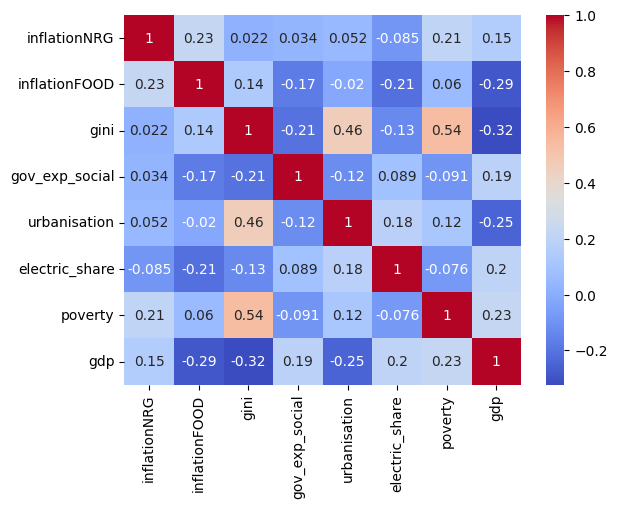

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Définir les variables d'entrée (X)
X = df_inflation_by_quintile[['inflationNRG', 'inflationFOOD', 'gini', 'gov_exp_social', 'urbanisation', 'electric_share', 'poverty', 'gdp']]

# Calculer la matrice de corrélation
corr_matrix = X.corr()

# Afficher la matrice de corrélation sous forme de heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()



In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_inflation_by_quintile[['inflationNRG', 'inflationFOOD', 'gini', 'gov_exp_social', 'urbanisation', 'electric_share', 'poverty']], df_inflation_by_quintile['Q1-Q5'], test_size=0.2, random_state=42)

# Créer un modèle de régression linéaire avec régularisation L2 (Ridge)
ridge = Ridge(alpha=1.0)

# Entraîner le modèle sur les données d'entraînement
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

# Calculer les métriques de performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Afficher les résultats
print("Score du modèle: ", ridge.score(X_test, y_test))
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R^2: ", r2)
print("Coefficients: ", ridge.coef_)
print("P-values: ", ridge.coef_)


Score du modèle:  0.5307645902627776
MSE:  1.2430297430757538
RMSE:  1.114912437402935
R^2:  0.5307645902627776
Coefficients:  [ 0.03463111  0.07590676 -0.00212295 -0.04653222  0.00707921  0.00272944
  0.08167056]
P-values:  [ 0.03463111  0.07590676 -0.00212295 -0.04653222  0.00707921  0.00272944
  0.08167056]


In [71]:
# Importer les bibliothèques nécessaires
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np



# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_inflation_by_quintile[['inflationNRG', 'inflationFOOD', 'gini', 'gov_exp_social', 'urbanisation', 'electric_share', 'poverty']], df_inflation_by_quintile['Q1-Q5'], test_size=0.2, random_state=42)

# Créer un modèle de régression linéaire avec régularisation L1 (Lasso)
lasso = Lasso(alpha=1.0)

# Entraîner le modèle sur les données d'entraînement
lasso.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = lasso.predict(X_test)

# Calculer les métriques de performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Afficher les résultats
print("Score du modèle: ", lasso.score(X_test, y_test))
print("MSE: ", mse)
print("RMSE: ", rmse)
print("R^2: ", r2)
print("Coefficients: ", lasso.coef_)


Score du modèle:  0.450687940489068
MSE:  1.455157079012152
RMSE:  1.2062989177696182
R^2:  0.450687940489068
Coefficients:  [ 0.03590737  0.06225334  0.         -0.          0.00173176 -0.
  0.00934502]
